# 20240915
★ shot grid 수정해야함.  그냥 단순히 step pitch로 쪼개놓은것임.-> 개선필요

1. Shot Left부분 그리기. 
   wafer정센터(0,0)에서 step_pitch의 절반만큼 -방향으로 이동. 
   
2. map shift 고려. 
   map shift만큼을 더해준다.

3. +방향에서는 step pitch만큼 n개씩 더해준다. 
   -방향에서는 step pitch만큼 m개씩 빼준다. 

# 20240915(2)
함수로 변경해줌

# 20240916
1. WF7.5로 테스트 해보기. OCM이랑 비교용
2. 화살표 머리부분 크기 조정. headwidth=2, headlength=3
3. 양수die, 음수die 정보를 매뉴얼로 넣어줘야하는 문제있음 -> max die, min die 정보를 활용. 대신에 vline, hline으로 나눠줘야함.

4. die x,y가 음수인 경우에 for문이 돌지않음. -> min에는 abs처리함.
5. shot left만 그려주는거라서 shot right부분 짤리는 경우있음 -> max_die + 2 처리해줌.(넉넉하게)
6. Die 위치 플롯기능은 삭제함.  die좌표계와 wf좌표계랑 안맞음.. 
   -> def plot_overlay(x, y, dx, dy, v_lines, h_lines, die_x, die_y, wafer_radius=150000, title='Wafer Vector Map'): 에서 die_x, die_y 삭제함.

7. lot_id 개별로 표현


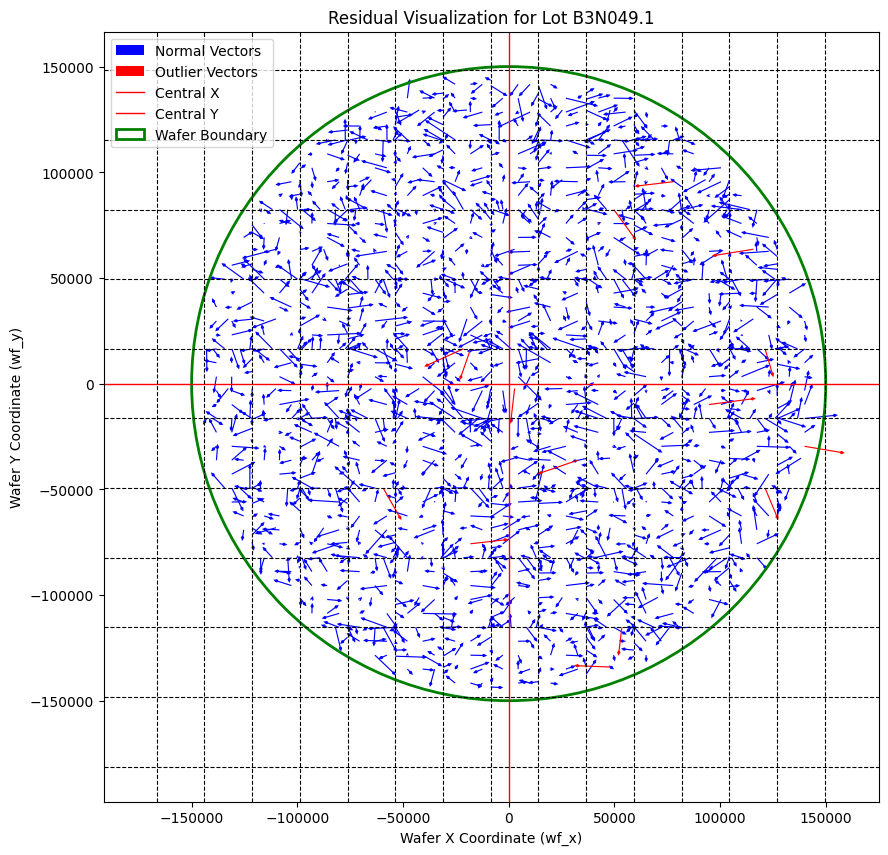

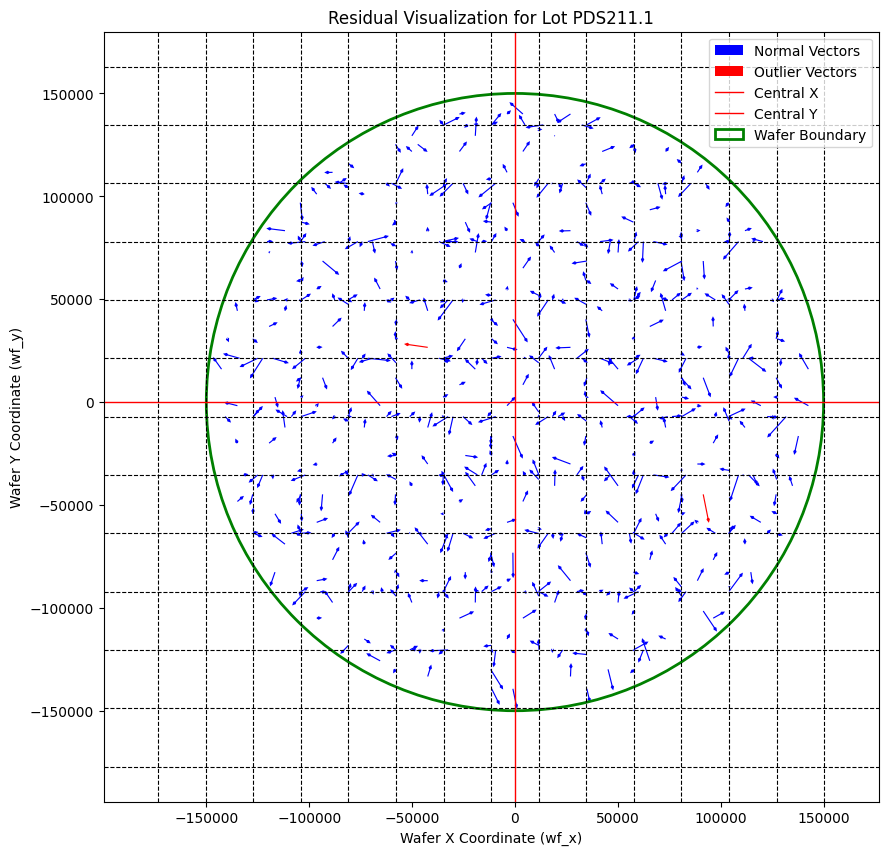

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 세로선을 계산하는 함수
def calculate_vlines(center, pitch, max_die_x, min_die_x):
    lines = []
    # 양의 방향
    current = center
    for _ in range(max_die_x + 2):
        lines.append(current)
        current += pitch
    # 음의 방향
    current = center
    for _ in range(abs(min_die_x) + 1):
        current -= pitch
        lines.append(current)
    return lines

# 가로선을 계산하는 함수
def calculate_hlines(center, pitch, max_die_y, min_die_y ):
    lines = []
    # 양의 방향
    current = center
    for _ in range(max_die_y + 2):
        lines.append(current)
        current += pitch
    # 음의 방향
    current = center
    for _ in range(abs(min_die_y) + 1):
        current -= pitch
        lines.append(current)
    return lines


def plot_overlay(
    x, y, dx, dy, 
    v_lines, h_lines, 
    wafer_radius=150000, 
    title='Wafer Vector Map', 
    scale_factor=1e-7,
    outlier_mask=None
):
    """
    기존 코드와 동일한 파라미터:
      x, y: 좌표
      dx, dy: 벡터 (예: residual_x, residual_y)
      v_lines, h_lines: 수직/수평선 리스트
      wafer_radius: 웨이퍼 반경
      title: 그래프 제목
      scale_factor: quiver 함수의 scale과 연결. (기존 코드에서는 scale=1e-7로 고정)
      outlier_mask: (Optional) 이상치 여부를 나타내는 boolean array/Series.
                    True인 곳만 분리해서 다른 색으로 표시.
                    None이면 전체를 한 색(파란색)으로만 표시.
    """
    plt.figure(figsize=(10, 10))

    # outlier_mask가 없으면, 전체를 한 번에 그림(기존 코드와 동일)
    if outlier_mask is None:
        plt.quiver(
            x, y, dx, dy,
            angles='xy', scale_units='xy', scale=1e-7,  # 기존 코드 그대로
            color='blue', label='Overlay Vectors',
            width=0.0015, headwidth=3, headlength=3
        )
    else:
        # outlier_mask가 있으면, 정상/이상치를 나눠서 그린다
        x_normal = x[~outlier_mask]
        y_normal = y[~outlier_mask]
        dx_normal = dx[~outlier_mask]
        dy_normal = dy[~outlier_mask]

        x_outlier = x[outlier_mask]
        y_outlier = y[outlier_mask]
        dx_outlier = dx[outlier_mask]
        dy_outlier = dy[outlier_mask]

        # 1) 정상 데이터(blue)
        plt.quiver(
            x_normal, y_normal,
            dx_normal, dy_normal,
            angles='xy', scale_units='xy', scale=1e-7,  # 기존 코드와 동일
            color='blue', label='Normal Vectors',
            width=0.0015, headwidth=3, headlength=3
        )
        # 2) 이상치 데이터(red)
        if len(x_outlier) > 0:
            plt.quiver(
                x_outlier, y_outlier,
                dx_outlier, dy_outlier,
                angles='xy', scale_units='xy', scale=1e-7,
                color='red', label='Outlier Vectors',
                width=0.0015, headwidth=3, headlength=3
            )

    # 중앙선
    plt.axvline(0, color='red', linewidth=1.0, label='Central X')
    plt.axhline(0, color='red', linewidth=1.0, label='Central Y')

    # 수직선
    for vline in v_lines:
        plt.axvline(vline, color='black', linestyle='--', linewidth=0.8)

    # 수평선
    for hline in h_lines:
        plt.axhline(hline, color='black', linestyle='--', linewidth=0.8)

    # 웨이퍼 경계 원 추가
    wafer_circle = plt.Circle(
        (0, 0), wafer_radius, color='green', fill=False,
        linestyle='-', linewidth=2, label='Wafer Boundary'
    )
    plt.gca().add_patch(wafer_circle)

    plt.xlabel('Wafer X Coordinate (wf_x)')
    plt.ylabel('Wafer Y Coordinate (wf_y)')
    plt.title(title)
    plt.axis('equal')
    plt.grid(False)
    plt.legend()
    plt.show()

def main():
    file_path = 'Delta_PSM.csv'
    df = pd.read_csv(file_path)

    lot_ids = df['LOT_ID'].unique()

    for lot_id in lot_ids:
        df_lot = df[df['LOT_ID'] == lot_id]

        wf_x = df_lot['wf_x']
        wf_y = df_lot['wf_y']
        residual_x = df_lot['residual_x']
        residual_y = df_lot['residual_y']

        step_pitch_x = df_lot['STEP_PITCH_X'].iloc[0]
        step_pitch_y = df_lot['STEP_PITCH_Y'].iloc[0]
        map_shift_x  = df_lot['MAP_SHIFT_X'].iloc[0]
        map_shift_y  = df_lot['MAP_SHIFT_Y'].iloc[0]

        start_left   = -(step_pitch_x) / 2 + map_shift_x
        start_bottom = -(step_pitch_y) / 2 + map_shift_y
        max_die_x = max(df_lot['DieX'])
        min_die_x = min(df_lot['DieX'])
        max_die_y = max(df_lot['DieY'])
        min_die_y = min(df_lot['DieY'])

        vertical_lines   = calculate_vlines(start_left, step_pitch_x, max_die_x, min_die_x)
        horizontal_lines = calculate_hlines(start_bottom, step_pitch_y, max_die_y, min_die_y)

        # (예) df_lot['is_outlier']가 있다고 가정. 
        #     없으면 None을 넣어서 그냥 전체 파란색으로만 표시됨.
        outlier_mask = None
        if 'is_outlier' in df_lot.columns:
            outlier_mask = df_lot['is_outlier']

        plot_overlay(
            x=wf_x,
            y=wf_y,
            dx=residual_x,
            dy=residual_y,
            v_lines=vertical_lines,
            h_lines=horizontal_lines,
            wafer_radius=150000,
            title=f'Residual Visualization for Lot {lot_id}',
            scale_factor=3e-8,  # 예: main에서 이 값을 변경
            outlier_mask=outlier_mask
        )


if __name__ == "__main__":
    main()

